# HW2: Classification

In [2]:
# HomeworkID
HOMEWORK_ID = "hw2"
# Res Directory
RES_DIR = f"res/{HOMEWORK_ID}/"
# Output Directory
OUTPUT_DIR = f"output/{HOMEWORK_ID}/"
# Random Seed
RANDOM_SEED = 42

In [3]:
# Import packages
# Standard libraries
import os
import csv
import random
import gc
import numpy as np
import pandas as pd

# Pytorch and Keras
import torch
import keras
from keras import layers
from keras.utils import PyDataset

# For plotting
import matplotlib.pyplot as plt

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
# Utilities
def get_device():
    ''' Returns the available device: GPU if available, else CPU '''
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed_value=RANDOM_SEED):
    ''' Sets the random seed for reproducibility '''
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True # 强制CuDNN使用确定性算法
        torch.backends.cudnn.benchmark = False # 关闭CuDNN的自动优化功能

def plot_learning_curve(loss_record: dict, title: str):
    ''' Plots the learning curve '''
    total_epochs = len(loss_record['loss'])
    x_train = np.arange(1, total_epochs + 1)
    x_val = x_train[::len(x_train)//len(loss_record['val_loss'])]
    plt.figure(figsize=(10, 6))
    plt.plot(x_train, loss_record['loss'], c='tab:red', label='Training Loss')
    plt.plot(x_val, loss_record['val_loss'], c='tab:blue', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# GPU Checking
print(f"{'='*40}")
print(f"Using device: {get_device()}")
print(f"PyTorch version: {torch.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Current Backend: {keras.backend.backend()}")
print(f"{'='*40}")

# Set random seed for reproducibility
set_random_seed(RANDOM_SEED)
print(f"Random seed set to: {RANDOM_SEED}")
print(f"{'='*40}")

# Make sure OUTPUT_DIR exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

Using device: cuda
PyTorch version: 2.9.1+cu130
Keras Version: 3.13.0
Current Backend: torch
Random seed set to: 42


## Phoneme Classification
### The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.  
TIMIT 朗读语音语料库的设计目的是，为声学 - 音素知识的获取，以及自动语音识别系统的开发与评估，提供语音数据支持。

This homework is a multiclass classification task, 
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.  
本次作业为多分类任务，我们将训练一个深度神经网络分类器，基于 TIMIT 语音语料库，对每一帧的音素进行预测。

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

### Preparing Data

Load the training and testing data from the `.npy` file (NumPy array).

In [6]:
# trainData, train_11.npy
TRAIN_DATA_PATH = os.path.join(RES_DIR, "train_11.npy")
train_data = np.load(TRAIN_DATA_PATH)
print(f"Loaded training data from {TRAIN_DATA_PATH} with shape {train_data.shape}")
# trainLabels, train_label_11.npy
TRAIN_LABELS_PATH = os.path.join(RES_DIR, "train_label_11.npy")
train_labels = np.load(TRAIN_LABELS_PATH)
print(f"Loaded training labels from {TRAIN_LABELS_PATH} with shape {train_labels.shape}")
# testData, test_11.npy
TEST_DATA_PATH = os.path.join(RES_DIR, "test_11.npy")
test_data = np.load(TEST_DATA_PATH)
print(f"Loaded test data from {TEST_DATA_PATH} with shape {test_data.shape}")

Loaded training data from res/hw2/train_11.npy with shape (1229932, 429)
Loaded training labels from res/hw2/train_label_11.npy with shape (1229932,)
Loaded test data from res/hw2/test_11.npy with shape (451552, 429)


### Dataset and Model

In [7]:
# Dataset
class TIMITDataset(PyDataset):
    def __init__(self, X, y=None, batch_size=32, shuffle=True):
        super().__init__()
        self.data = X.astype(np.float32)
        if y is not None:
            self.labels = y.astype(np.int32)
        else:
            self.labels = None
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))

        if self.shuffle and self.labels is not None:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError(f"Index {idx} out of range for dataset of length {len(self)}")

        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.data))

        # 如果使用了 shuffle，通过 indices 获取实际数据
        if hasattr(self, 'indices') and self.indices is not None:
            batch_indices = self.indices[start_idx:end_idx]
        else:
            batch_indices = slice(start_idx, end_idx)
        
        batch_X = self.data[batch_indices]
        
        if self.labels is not None:
            batch_y = self.labels[batch_indices]
            return batch_X, batch_y
        else:
            return batch_X
        
    def on_epoch_end(self):
        if self.shuffle and self.labels is not None:
            np.random.shuffle(self.indices)


In [8]:
# Model
def create_neural_net(hidden_units=[64]):
    # input layer
    inputs = keras.Input(shape=(429,))
    x = inputs
    # hidden layers
    for units in hidden_units:
        x = layers.Dense(units, activation='sigmoid')(x)
    # output layer
    outputs = layers.Dense(39, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Hyperparameters

In [9]:
validation_split = 0.2
hidden_units = [1024,512,128]
batch_size = 64
epochs = 20
learning_rate = 1e-4

### Train

In [10]:
# 切分训练集和验证集
num_samples = len(train_data)
indices = np.arange(num_samples)
split = int(np.floor(validation_split * num_samples))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(f"Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")
# 创建Dataset
train_dataset = TIMITDataset(train_data[train_indices], train_labels[train_indices], batch_size=batch_size, shuffle=True)
val_dataset = TIMITDataset(train_data[val_indices], train_labels[val_indices], batch_size=batch_size, shuffle=False)
# 创建模型 CrossEntropyLoss
model = create_neural_net(hidden_units=hidden_units)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

# gc
del train_data, train_labels
gc.collect()

Training samples: 983946, Validation samples: 245986


1001

Epoch 1/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.5002 - loss: 1.7080 - val_accuracy: 0.5884 - val_loss: 1.3648
Epoch 2/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 110s 7ms/step - accuracy: 0.6189 - loss: 1.2480 - val_accuracy: 0.6442 - val_loss: 1.1559
Epoch 3/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.6614 - loss: 1.0923 - val_accuracy: 0.6695 - val_loss: 1.0580
Epoch 4/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.6857 - loss: 1.0027 - val_accuracy: 0.6855 - val_loss: 0.9964
Epoch 5/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.7023 - loss: 0.9423 - val_accuracy: 0.6977 - val_loss: 0.9517
Epoch 6/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 121s 8ms/step - accuracy: 0.7145 - loss: 0.8974 - val_accuracy: 0.7045 - val_loss: 0.9234
Epoch 7/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 112s 7ms/step - accuracy: 0.7245 - loss: 0.8617 - val_accuracy: 0.7093 - val_loss: 0.9042
Epoch 8/20
15375/15375 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - ac

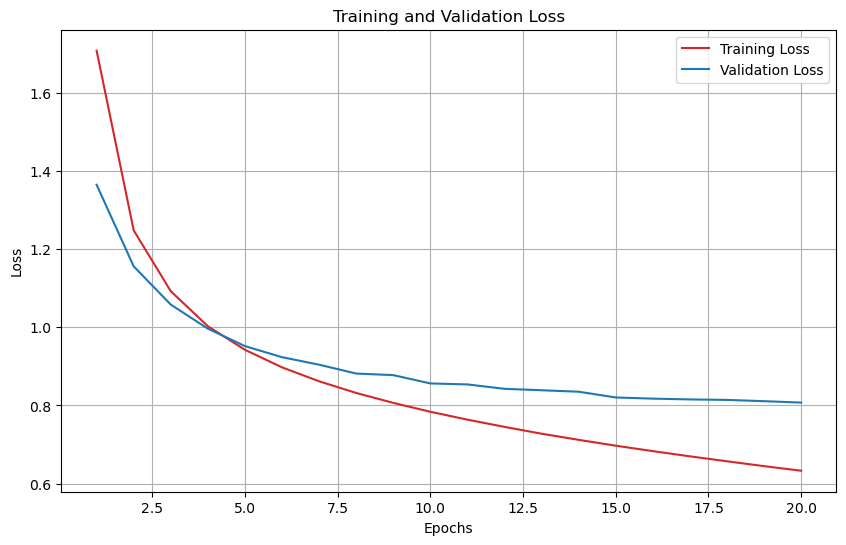

In [11]:
# Training
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs)
# Saving the trained model
model.save(os.path.join(OUTPUT_DIR, f'model_lr{learning_rate}_bs{batch_size}_epochs{epochs}.keras'))
# Plot learning curve
plot_learning_curve(history.history, title="Training and Validation Loss")

### Testing

In [12]:
# 创建Dataset
test_dataset = TIMITDataset(test_data, batch_size=batch_size, shuffle=False)

# Prediction
predictions = model.predict(test_dataset)

# Save predictions to CSV
OUTPUT_CSV_PATH = os.path.join(OUTPUT_DIR, "predictions.csv")
with open(OUTPUT_CSV_PATH, 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['Id', 'Class'])
    for i, pred in enumerate(predictions):
        predicted_class = np.argmax(pred)
        writer.writerow([i, predicted_class])


7056/7056 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


## Hessian Matrix
Imagine we are training a neural network and we are trying to find out whether the model is at **local minima like, saddle point, or none of the above**. We can make our decision by calculating the Hessian matrix. 想象我们正在训练一个神经网络，并试图判断模型是否处于类局部极小值点、鞍点，或两者都不是。我们可以通过计算海森矩阵来做出判断。

In practice, it is really hard to find a point where the gradient equals zero or all of the eigenvalues in Hessian matrix are greater than zero. In this homework, we make the following two assumptions:
1. View gradient norm less than 1e-3 as **gradient equals to zero**. 将梯度范数小于 1e-3 视为梯度等于零。  
2. If minimum ratio is greater than 0.5 and gradient norm is less than 1e-3, then we assume that the model is at “local minima like”. 如果最小比率大于 0.5 且梯度范数小于 1e-3，则认为模型处于类局部极小值点。  

> Minimum ratio is defined as the proportion of positive eigenvalues.  最小比率定义为：正特征值所占的比例。

In [14]:
# Import packages
from math import pi
from collections import defaultdict
from autograd_lib import autograd_lib

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

### Define NN Model
The NN model here is used to fit a single variable math function.
$$f(x) = \frac{\sin(5\pi x)}{5\pi x}.$$

In [15]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x

### Load Pretrained Checkpoints and Training Data

In [16]:
model = MathRegressor()
autograd_lib.register(model)

DATA_PATH = os.path.join(RES_DIR, "data.pth")
data = torch.load(DATA_PATH)[7]
model.load_state_dict(data['model'])
train, target = data['data']

### Mathematical Derivation

In [17]:
# reset compute dictionaries
activations  = defaultdict(int)
hess = defaultdict(float)

In [28]:
# function to compute gradient norm
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) # compute mean of gradient norms

    return grad_mean

# helper function to save activations
def save_activations(layer, A, _):
    '''
    A is the input of the layer, we use batch size of 6 here
    layer 1: A has size of (6, 1)
    layer 2: A has size of (6, 128)
    '''
    activations[layer] = A

# helper function to compute Hessian matrix
def compute_hess(layer, _, B):
    '''
    B is the backprop value of the layer
    layer 1: B has size of (6, 128)
    layer 2: B ahs size of (6, 1)
    '''
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) # do batch-wise outer product

    # full Hessian
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA) # do batch-wise outer product, then sum over the batch

# function to compute the minimum ratio
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    # compute Hessian matrix
    # save the gradient of each layer
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    # compute Hessian according to the gradient value stored in the previous step
    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    # compute eigenvalues of the Hessian matrix
    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        eigvals = torch.linalg.eigvalsh(h)  # 新API，只计算特征值
        num_greater = torch.sum(eigvals > 0).item()
        minimum_ratio.append(num_greater / len(eigvals))

    ratio_mean = np.mean(minimum_ratio) # compute mean of minimum ratio

    return ratio_mean

In [29]:
# compute Hessian
criterion = nn.MSELoss()
grad_norm = compute_gradient_norm(model, criterion, train, target)
min_ratio = compute_minimum_ratio(model, criterion, train, target)
print(f"Gradient Norm: {grad_norm}")
print(f"Minimum Ratio: {min_ratio}")

Gradient Norm: 0.0003471799755061511
Minimum Ratio: 0.45703125
